<h2 style='text-align: center'>Transfer Learning</h2>

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import time
from datetime import timedelta
import os

# Functions and classes for loading and using the Inception model.
import inception

# We use Pretty Tensor to define the new classifier.
# import prettytensor as pt
import tensorflow as tf

In [2]:
tf.__version__

'0.12.0-rc0'

In [3]:
import cifar10
from cifar10 import num_classes

In [4]:
#loading the dataset
cifar10.data_path = "data/CIFAR-10/"

In [5]:
cifar10.maybe_download_and_extract()

Data has apparently already been downloaded and unpacked.


In [6]:
class_names = cifar10.load_class_names()
class_names

Loading data: data/CIFAR-10/cifar-10-batches-py/batches.meta


['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [7]:
images_train, cls_train, labels_train = cifar10.load_training_data()

Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_1
Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_2
Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_3
Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_4
Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_5


In [8]:
labels_train[:2]

array([[ 0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]])

In [9]:
images_test, cls_test, labels_test = cifar10.load_test_data()

Loading data: data/CIFAR-10/cifar-10-batches-py/test_batch


In [10]:
images_train[0].shape

(32, 32, 3)

## Plotting

In [11]:
def plot_images(images, cls_true, cls_pred=None, smooth=True):

    assert len(images) == len(cls_true)

    # Create figure with sub-plots.
    fig, axes = plt.subplots(3, 3)

    # Adjust vertical spacing.
    if cls_pred is None:
        hspace = 0.3
    else:
        hspace = 0.6
    fig.subplots_adjust(hspace=hspace, wspace=0.3)

    # Interpolation type.
    if smooth:
        interpolation = 'spline16'
    else:
        interpolation = 'nearest'

    for i, ax in enumerate(axes.flat):
        # There may be less than 9 images, ensure it doesn't crash.
        if i < len(images):
            # Plot image.
            ax.imshow(images[i],
                      interpolation=interpolation)

            # Name of the true class.
            cls_true_name = class_names[cls_true[i]]

            # Show true and predicted classes.
            if cls_pred is None:
                xlabel = "True: {0}".format(cls_true_name)
            else:
                # Name of the predicted class.
                cls_pred_name = class_names[cls_pred[i]]

                xlabel = "True: {0}\nPred: {1}".format(cls_true_name, cls_pred_name)

            # Show the classes as the label on the x-axis.
            ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()


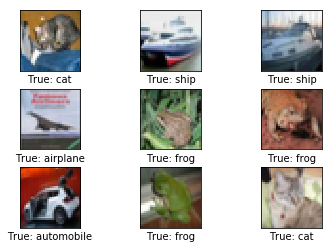

In [12]:
# Get the first images from the test-set.
images = images_test[0:9]

# Get the true classes for those images.
cls_true = cls_test[0:9]

# Plot the images and labels using our helper-function above.
plot_images(images=images, cls_true=cls_true, smooth=False)

## Big net download

Download the huge net for transfer

In [13]:
inception.data_dir = 'inception/'


In [14]:
inception.maybe_download()

Data has apparently already been downloaded and unpacked.


In [15]:
model = inception.Inception()

In [105]:
images_train[:1].shape

(1, 32, 32, 3)

In [17]:
from inception import transfer_values_cache

In [18]:
file_path_cache_train = os.path.join(cifar10.data_path, 'inception_cifar10_train.pkl')
file_path_cache_test = os.path.join(cifar10.data_path, 'inception_cifar10_test.pkl')

In [19]:
print("Processing Inception transfer-values for training-images ...")

# Scale images because Inception needs pixels to be between 0 and 255,
# while the CIFAR-10 functions return pixels between 0.0 and 1.0

#scale down the sample
# images_train

images_scaled = images_train[:10000] * 255.0

# If transfer-values have already been calculated then reload them,
# otherwise calculate them and save them to a cache-file.
transfer_values_train = transfer_values_cache(cache_path=file_path_cache_train,
                                              images=images_scaled,
                                              model=model)

Processing Inception transfer-values for training-images ...
- Data loaded from cache-file: data/CIFAR-10/inception_cifar10_train.pkl


In [20]:
print("Processing Inception transfer-values for test-images ...")

# Scale images because Inception needs pixels to be between 0 and 255,
# while the CIFAR-10 functions return pixels between 0.0 and 1.0
images_scaled = images_test[:5000] * 255.0

# If transfer-values have already been calculated then reload them,
# otherwise calculate them and save them to a cache-file.
transfer_values_test = transfer_values_cache(cache_path=file_path_cache_test,
                                             images=images_scaled,
                                             model=model)

Processing Inception transfer-values for test-images ...
- Data loaded from cache-file: data/CIFAR-10/inception_cifar10_test.pkl


In [21]:
transfer_values_train.shape

(10000, 2048)

## Plotting transfer values

In [22]:
def plot_transfer_values(i):
    print("Input image:")
    
    # Plot the i'th image from the test-set.
    plt.imshow(images_test[i], interpolation='nearest')
    plt.show()

    print("Transfer-values for the image using Inception model:")
    
    # Transform the transfer-values into an image.
    img = transfer_values_test[i]
    img = img.reshape((32, 64))

    # Plot the image for the transfer-values.
    plt.imshow(img, interpolation='nearest', cmap='Reds')
    plt.show()

Input image:


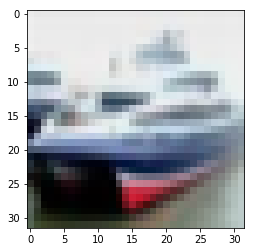

Transfer-values for the image using Inception model:


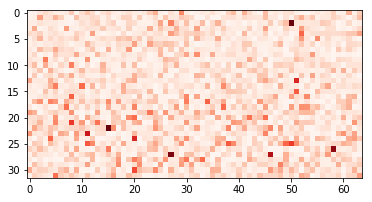

In [23]:
plot_transfer_values(i=1)

## Analysis of transfer values with PCA

In [24]:
def plot_scatter(values, cls):
    # Create a color-map with a different color for each class.
    import matplotlib.cm as cm
    cmap = cm.rainbow(np.linspace(0.0, 1.0, num_classes))

    # Get the color for each sample.
    colors = cmap[cls]

    # Extract the x- and y-values.
    x = values[:, 0]
    y = values[:, 1]

    # Plot it.
    plt.scatter(x, y, color=colors)
    plt.show()

In [25]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

transfer_values = transfer_values_train[0:3000]
cls = cls_train[0:3000]

pca = PCA(n_components=50)
transfer_values_50d = pca.fit_transform(transfer_values)


In [26]:
tsne = TSNE(n_components=2)
transfer_values_reduced = tsne.fit_transform(transfer_values_50d)
transfer_values_reduced.shape

(3000, 2)

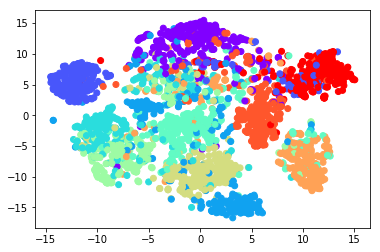

In [27]:
plot_scatter(transfer_values_reduced, cls)

In [28]:
transfer_len = model.transfer_len
transfer_len


Dimension(2048)

In [29]:
transfer_values_train[:1].shape

(1, 2048)

In [30]:
transfer_len

Dimension(2048)

## Create NN.

Receives transfer values array and outputs the predicted classes.

#### Variables

In [82]:
transfer_len

Dimension(2048)

In [83]:
#placeholders
x = tf.placeholder(tf.float32, shape=[None, transfer_len], name='x')
y_true = tf.placeholder(tf.float32, shape=[None, num_classes], name='y_true')
y_true_cls = tf.arg_max(y_true, dimension=1)

#### NN graph

In [84]:
#Fully connected net
w1 = tf.Variable(tf.truncated_normal(shape=[2048, 1024], stddev=0.05))
b1 = tf.constant(0.05, shape=[1024])
layer_1 = tf.nn.relu(tf.matmul(x, w1) + b1) #[None, 1024]

w2 = tf.Variable(tf.truncated_normal(shape=[1024, 10], stddev=0.05))
b2 = tf.constant(0.05, shape=[10])
layer_2 = tf.matmul(layer_1, w2) + b2 #[None, 10]

#### Predictions

In [85]:
y_pred = tf.nn.softmax(layer_2)
y_pred_cls = tf.argmax(y_pred, dimension=1)

#### Cost

In [86]:
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=layer_2,
                                                        labels=y_true)
cost = tf.reduce_mean(cross_entropy)

#### Optimize

In [87]:
optimizer = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(cost)

#### Performance Metric

In [88]:
correct_prediction = tf.equal(y_pred_cls, y_true_cls)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

### Run the session

In [89]:
session = tf.Session()
session.run(tf.global_variables_initializer())

In [90]:
train_batch_size = 64
def random_batch():
    # Number of images (transfer-values) in the training-set.
    num_images = len(transfer_values_train)

    # Create a random index.
    idx = np.random.choice(num_images,
                           size=train_batch_size,
                           replace=False)

    # Use the random index to select random x and y-values.
    # We use the transfer-values instead of images as x-values.
    x_batch = transfer_values_train[idx]
    y_batch = labels_train[idx]

    return x_batch, y_batch

In [91]:
transfer_values_test.shape

(5000, 2048)

In [92]:
def optimize(num_iterations):
    # Start-time used for printing time-usage below.
    start_time = time.time()

    for i in range(num_iterations):
        # Get a batch of training examples.
        # x_batch now holds a batch of images (transfer-values) and
        # y_true_batch are the true labels for those images.
        x_batch, y_true_batch = random_batch()

        # Put the batch into a dict with the proper names
        # for placeholder variables in the TensorFlow graph.
        feed_dict_train = {x: x_batch,
                           y_true: y_true_batch}

        # Run the optimizer using this batch of training data.
        # TensorFlow assigns the variables in feed_dict_train
        # to the placeholder variables and then runs the optimizer.
        # We also want to retrieve the global_step counter.
        session.run(optimizer, feed_dict=feed_dict_train)

        # Print status to screen every 100 iterations (and last).
#         if (i_global % 100 == 0) or (i == num_iterations - 1):
        if (i % 100 == 0) or (i == num_iterations - 1):
            # Calculate the accuracy on the training-batch.
            batch_acc = session.run(accuracy,
                                    feed_dict=feed_dict_train)
            # Message for printing.
            msg = "Optimization Iteration: {0:>6}, Training Batch Accuracy: {1:>6.1%}"

            # Print it.
            print(msg.format(i + 1, batch_acc))

#             # Print status.
#             msg = "Global Step: {0:>6}, Training Batch Accuracy: {1:>6.1%}"
#             print(msg.format(i_global, batch_acc))

    # Ending time.
    end_time = time.time()

    # Difference between start and end-times.
    time_dif = end_time - start_time

    # Print the time-usage.
    print("Time usage: " + str(timedelta(seconds=int(round(time_dif)))))

In [93]:
optimize(num_iterations=2000)

Optimization Iteration:      1, Training Accuracy:  31.2%
Optimization Iteration:    101, Training Accuracy:  89.1%
Optimization Iteration:    201, Training Accuracy:  93.8%
Optimization Iteration:    301, Training Accuracy:  87.5%
Optimization Iteration:    401, Training Accuracy:  93.8%
Optimization Iteration:    501, Training Accuracy:  87.5%
Optimization Iteration:    601, Training Accuracy:  93.8%
Optimization Iteration:    701, Training Accuracy:  93.8%
Optimization Iteration:    801, Training Accuracy:  95.3%
Optimization Iteration:    901, Training Accuracy:  96.9%
Optimization Iteration:   1001, Training Accuracy:  96.9%
Optimization Iteration:   1101, Training Accuracy:  93.8%
Optimization Iteration:   1201, Training Accuracy:  92.2%
Optimization Iteration:   1301, Training Accuracy:  98.4%
Optimization Iteration:   1401, Training Accuracy:  95.3%
Optimization Iteration:   1501, Training Accuracy:  96.9%
Optimization Iteration:   1601, Training Accuracy:  96.9%
Optimization I

In [69]:

#true test values are in: cls_test
#
labels_test[:5]

array([[ 0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.],
       [ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.]])

In [70]:
# cls_test[:5]

#### Predict two elements example

In [71]:
feed_dict = {x: transfer_values_test[:2],
                     y_true: labels_test[:2]}

# Calculate the predicted class using TensorFlow.

cls_pred = session.run(y_pred_cls, feed_dict=feed_dict)
cls_pred

array([3, 8])

### Evaluate Model on test set

In [72]:
# Split the data-set in batches of this size to limit RAM usage.
batch_size = 256

def predict_cls(transfer_values, labels, cls_true):
    # Number of images.
    num_images = len(transfer_values)

    # Allocate an array for the predicted classes which
    # will be calculated in batches and filled into this array.
    cls_pred = np.zeros(shape=num_images, dtype=np.int)

    # Now calculate the predicted classes for the batches.
    # We will just iterate through all the batches.
    # There might be a more clever and Pythonic way of doing this.

    # The starting index for the next batch is denoted i.
    i = 0

    while i < num_images:
        # The ending index for the next batch is denoted j.
        j = min(i + batch_size, num_images)

        # Create a feed-dict with the images and labels
        # between index i and j.
        feed_dict = {x: transfer_values[i:j],
                     y_true: labels[i:j]}

        # Calculate the predicted class using TensorFlow.
        cls_pred[i:j] = session.run(y_pred_cls, feed_dict=feed_dict)

        # Set the start-index for the next batch to the
        # end-index of the current batch.
        i = j
        
    # Create a boolean array whether each image is correctly classified.
#     correct = (cls_true == cls_pred)

#     return correct, cls_pred
    return cls_pred


In [73]:
#Calculate predicted classes on the test set
cls_pred = predict_cls(transfer_values=transfer_values_test, labels=labels_test, cls_true=cls_test)

In [99]:
#checking the shape
cls_pred.shape, cls_test[:5000].shape

((5000,), (5000,))

### Confusion Matrix

In [76]:
from sklearn.metrics import confusion_matrix
y_true = [2, 0, 2, 2, 0, 1]
y_pred = [0, 0, 2, 2, 0, 2]
confusion_matrix(y_true, y_pred)

array([[2, 0, 0],
       [0, 0, 1],
       [1, 0, 2]])

In [77]:
confusion_matrix(cls_test[:5000], cls_pred)

array([[429,   2,   9,   3,   7,   0,   1,   4,  22,  11],
       [  5, 467,   1,   1,   0,   0,   2,   0,   1,  28],
       [  8,   1, 440,  14,  24,  11,  12,   1,   0,   1],
       [  3,   0,  16, 380,   8,  71,  11,   6,   1,   1],
       [  8,   0,  18,  13, 436,   5,  13,  13,   1,   0],
       [  1,   0,   5,  30,   7, 440,   1,   3,   0,   1],
       [  2,   0,  11,  18,  13,   6, 438,   1,   1,   1],
       [  4,   0,   4,   4,  19,  24,   2, 433,   2,   3],
       [ 19,   3,   1,   1,   1,   1,   1,   1, 469,   7],
       [  6,  14,   2,   2,   1,   2,   1,   0,   4, 481]])

In [100]:
class_names

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

### Production - Predict an Image of Cat

Grab an img from the internet of a cat and predict the image